In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate, ZeroPadding2D

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [2]:
currentPath = os.getcwd()
print(currentPath)

C:\Users\CARLOS CORDERO\Desktop\ToG_pretrain


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


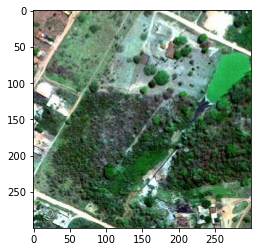

In [4]:
trainDB = currentPath + os.sep + "train20"
valDB = currentPath + os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
DenseNetWeightsPretrained = currentPath + os.sep + "DenseNet-BC-161-48-no-top.h5"
model_name = "DenseNet-161"
classList = os.listdir(trainDB)

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_7_8_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00016
batch_size = 10
num_epochs = 200
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 105 images belonging to 7 classes.
Found 34 images belonging to 7 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6}


In [8]:
convcnt = 1
def bn_relu_conv(x, filters, kernel_size):
    global convcnt
    convcnt = convcnt + 1
    x = BatchNormalization(name= "batch_normalization_"+str(convcnt))(x)
    x = ReLU()(x) 
    x = Conv2D(filters, kernel_size, padding="same", name= "conv2d_"+str(convcnt), use_bias=False)(x)
    return x

In [9]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_relu_conv(tensor, 4*k, 1)
        x = bn_relu_conv(x, k, 3)
        tensor = Concatenate()([tensor, x])
    return tensor

In [10]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_relu_conv(x, f, 1)
    x = AvgPool2D(2, strides=2, padding="same")(x)
    return x

In [11]:
def densenet_161( imageShape, weights):
    k = 48
    theta = 0.5
    repetitions = [6, 12, 36, 24]

    input = Input(shape=(imageShape))
    x = ZeroPadding2D(padding=(3, 3))(input)
    x = Conv2D(2*k, 7, strides=2, padding="valid", name="conv2d_1", use_bias=False)(x)
    x = BatchNormalization(name= "batch_normalization_input")(x)
    x = ReLU()(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPool2D(3, strides=2, padding="valid")(x)

    for reps in repetitions:
        denseBlock = dense_block(x, k, reps)
        x = transition_layer(denseBlock, theta)

    model = Model(input, denseBlock)
    model.load_weights(weights, by_name=True)
    
    x = GlobalAvgPool2D()(denseBlock)
    output = Dense(num_categories, activation="softmax")(x)
    model = Model(input, output)
        
    return model



In [12]:
model = densenet_161((img_rows, img_cols, img_channel), DenseNetWeightsPretrained)

model.summary()
#plot_model(model, show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 96) 14112       zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_input (Batc (None, 112, 112, 96) 384         conv2d_1[0][0]                   
____________________________________________________________________________________________

Total params: 26,698,567
Trainable params: 26,483,047
Non-trainable params: 215,520
__________________________________________________________________________________________________


In [13]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[tensorflow.keras.callbacks.TensorBoard("logs/sample" + "/keras")],
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
4/4 [==============================] - 9s 2s/step - loss: 1.9485 - accuracy: 0.2000 - val_loss: 1.9600 - val_accuracy: 0.1176
Epoch 2/200
4/4 [==============================] - 2s 489ms/step - loss: 1.9345 - accuracy: 0.1250 - val_loss: 1.9417 - val_accuracy: 0.2941
Epoch 3/200
4/4 [==============================] - 12s 3s/step - loss: 1.8870 - accuracy: 0.1429 - val_loss: 1.9076 - val_accuracy: 0.1176
Epoch 4/200
4/4 [==============================] - 2s 485ms/step - loss: 1.8634 - accuracy: 0.3000 - val_loss: 1.8952 - val_accuracy: 0.2059
Epoch 5/200
4/4 [==============================] - 2s 489ms/step - loss: 1.7629 - accuracy: 0.3250 - val_loss: 1.8805 - val_accuracy: 0.1176
Epoch 6/200
4/4 [==============================] - 2s 488ms/step - loss: 1.6770 - accuracy: 0.3143 - val_loss: 2.1311 - val_accuracy: 0.1176
Epoch 7/200
4/4 [==============================] - 2s 488ms/step - loss: 1.6150 - a

Epoch 57/200
4/4 [==============================] - 2s 497ms/step - loss: 0.5455 - accuracy: 0.8000 - val_loss: 1.8724 - val_accuracy: 0.5588
Epoch 58/200
4/4 [==============================] - 2s 441ms/step - loss: 0.4332 - accuracy: 0.8286 - val_loss: 2.3868 - val_accuracy: 0.5000
Epoch 59/200
4/4 [==============================] - 2s 494ms/step - loss: 0.4566 - accuracy: 0.8500 - val_loss: 1.9076 - val_accuracy: 0.5000
Epoch 60/200
4/4 [==============================] - 2s 493ms/step - loss: 0.5342 - accuracy: 0.8000 - val_loss: 2.4117 - val_accuracy: 0.4412
Epoch 61/200
4/4 [==============================] - 2s 496ms/step - loss: 0.3201 - accuracy: 0.9429 - val_loss: 2.5969 - val_accuracy: 0.4118
Epoch 62/200
4/4 [==============================] - 2s 494ms/step - loss: 0.5717 - accuracy: 0.7750 - val_loss: 1.7445 - val_accuracy: 0.5588
Epoch 63/200
4/4 [==============================] - 2s 439ms/step - loss: 0.5434 - accuracy: 0.7714 - val_loss: 2.8555 - val_accuracy: 0.4118
Epoch 

4/4 [==============================] - 2s 496ms/step - loss: 0.2484 - accuracy: 0.9000 - val_loss: 2.5972 - val_accuracy: 0.5000
Epoch 115/200
4/4 [==============================] - 2s 496ms/step - loss: 0.1529 - accuracy: 0.9250 - val_loss: 3.0317 - val_accuracy: 0.3235
Epoch 116/200
4/4 [==============================] - 2s 494ms/step - loss: 0.3464 - accuracy: 0.8857 - val_loss: 2.9613 - val_accuracy: 0.4706
Epoch 117/200
4/4 [==============================] - 2s 497ms/step - loss: 0.3147 - accuracy: 0.9250 - val_loss: 4.8250 - val_accuracy: 0.3824
Epoch 118/200
4/4 [==============================] - 2s 445ms/step - loss: 0.1459 - accuracy: 0.9429 - val_loss: 8.2954 - val_accuracy: 0.2647
Epoch 119/200
4/4 [==============================] - 2s 495ms/step - loss: 0.3118 - accuracy: 0.9000 - val_loss: 5.0741 - val_accuracy: 0.4412
Epoch 120/200
4/4 [==============================] - 2s 496ms/step - loss: 0.1737 - accuracy: 0.9500 - val_loss: 4.3386 - val_accuracy: 0.3529
Epoch 121/200

4/4 [==============================] - 2s 498ms/step - loss: 0.0449 - accuracy: 1.0000 - val_loss: 2.4277 - val_accuracy: 0.5000
Epoch 172/200
4/4 [==============================] - 2s 496ms/step - loss: 0.0973 - accuracy: 0.9750 - val_loss: 2.8448 - val_accuracy: 0.4706
Epoch 173/200
4/4 [==============================] - 2s 442ms/step - loss: 0.1765 - accuracy: 0.9714 - val_loss: 2.5047 - val_accuracy: 0.5294
Epoch 174/200
4/4 [==============================] - 2s 497ms/step - loss: 0.0842 - accuracy: 0.9750 - val_loss: 3.1855 - val_accuracy: 0.3824
Epoch 175/200
4/4 [==============================] - 2s 496ms/step - loss: 0.0336 - accuracy: 1.0000 - val_loss: 2.6339 - val_accuracy: 0.3529
Epoch 176/200
4/4 [==============================] - 2s 439ms/step - loss: 0.1661 - accuracy: 0.9429 - val_loss: 3.1563 - val_accuracy: 0.3235
Epoch 177/200
4/4 [==============================] - 2s 496ms/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 3.0268 - val_accuracy: 0.3235
Epoch 178/200

In [15]:
model.save(currentPath + os.sep + "DenseNet161Model.h5")
model.save_weights(currentPath + os.sep + "DenseNet161Weights.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


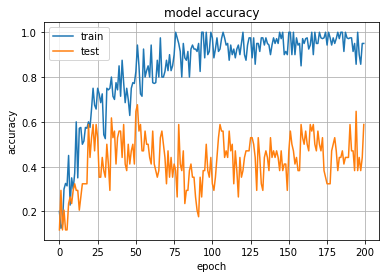

In [16]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

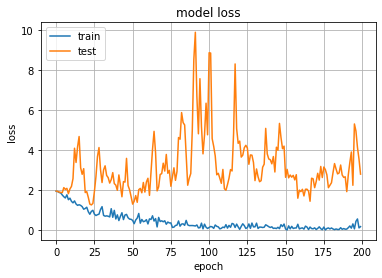

In [17]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [18]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_45_3_msrgb.jpg is: airport
file airport_55_0_msrgb.jpg is: airport
file airport_6_0_msrgb.jpg is: airport_hangar


In [19]:
loadedModel = load_model("DenseNet161Model.h5")

path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_45_3_msrgb.jpg is: airport
file airport_55_0_msrgb.jpg is: airport
file airport_6_0_msrgb.jpg is: airport_hangar
